[*********************100%%**********************]  1 of 1 completed


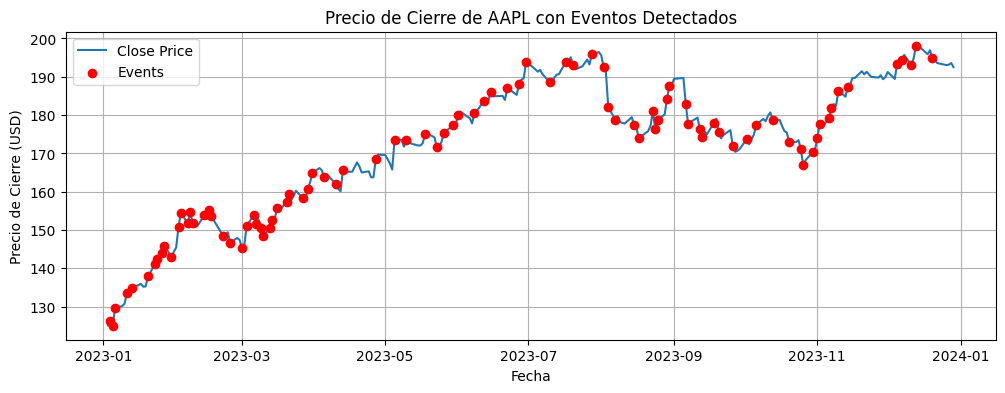

In [14]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Descargar datos históricos de Apple (AAPL)
data = yf.download("AAPL", start="2023-01-01", end="2024-01-01", interval="1d")

# Calcular los retornos diarios
data['Return'] = data['Close'].pct_change()

# Establecer un umbral para detectar eventos (e.g., 1% de cambio)
threshold = 0.01

# Crear una serie de eventos basada en el umbral
events = data.index[data['Return'].abs() > threshold].to_pydatetime()

# Visualizar los eventos
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['Close'], label='Close Price')
plt.scatter(events, data.loc[events, 'Close'], color='red', label='Events', zorder=5)
plt.title('Precio de Cierre de AAPL con Eventos Detectados')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
from scipy.optimize import minimize

def log_likelihood_hawkes(params, events):
    mu, alpha, beta = params
    n = len(events)
    log_likelihood = 0.0

    # Calculate log-likelihood
    for i in range(1, n):
        # Ensure intensity is not zero by adding a small epsilon
        intensity = mu + np.sum(alpha * np.exp(-beta * (events[i] - events[:i])))
        if intensity <= 0:
            return np.inf  # Penalize non-positive intensity

        log_likelihood += np.log(intensity)

    total_intensity = mu * events[-1] + alpha / beta * (1 - np.exp(-beta * (events[-1] - events)))
    log_likelihood -= np.sum(total_intensity)

    return -log_likelihood  # Negative because we minimize

# Initialize parameters with positive values
initial_params = [0.01, 0.1, 0.1]

# Convert events to a numerical format
event_times = np.array([event.timestamp() for event in events])

# Maximum Likelihood Estimation (MLE)
result = minimize(log_likelihood_hawkes, initial_params, args=(event_times,), bounds=[(0, None), (0, None), (0, None)])
mu_mle, alpha_mle, beta_mle = result.x

print("Estimación de Máxima Verosimilitud:")
print(f"mu = {mu_mle}, alpha = {alpha_mle}, beta = {beta_mle}")


Estimación de Máxima Verosimilitud:
mu = 0.006056184397174264, alpha = 0.060561843971742635, beta = 85.09999075928285


In [10]:
def hawkes_intensity(t, events, mu, alpha, beta):
    return mu + np.sum(alpha * np.exp(-beta * (t - events[events < t])))

def gradient_descent_hawkes(events, initial_params, learning_rate=0.01, epochs=1000):
    mu, alpha, beta = initial_params
    n = len(events)
    
    for _ in range(epochs):
        grad_mu = np.sum([1 / hawkes_intensity(ti, events, mu, alpha, beta) for ti in events]) - events[-1]
        grad_alpha = np.sum([np.sum(np.exp(-beta * (ti - events[events < ti])) / hawkes_intensity(ti, events, mu, alpha, beta)) for ti in events]) - np.sum((1 - np.exp(-beta * (events[-1] - events))) / beta)
        grad_beta = np.sum([np.sum((ti - events[events < ti]) * np.exp(-beta * (ti - events[events < ti])) / hawkes_intensity(ti, events, mu, alpha, beta)) for ti in events]) - np.sum((events[-1] - events) * np.exp(-beta * (events[-1] - events)))

        # Actualizar parámetros
        mu += learning_rate * grad_mu
        alpha += learning_rate * grad_alpha
        beta += learning_rate * grad_beta
    
    return mu, alpha, beta

# Estimar parámetros usando descenso de gradiente
initial_params = [0.1, 0.1, 0.1]
mu_opt, alpha_opt, beta_opt = gradient_descent_hawkes(event_times, initial_params)

print("Estimación por Optimización:")
print(f"mu = {mu_opt}, alpha = {alpha_opt}, beta = {beta_opt}")


Estimación por Optimización:
mu = -17030483990.8, alpha = -8999.9, beta = 0.1


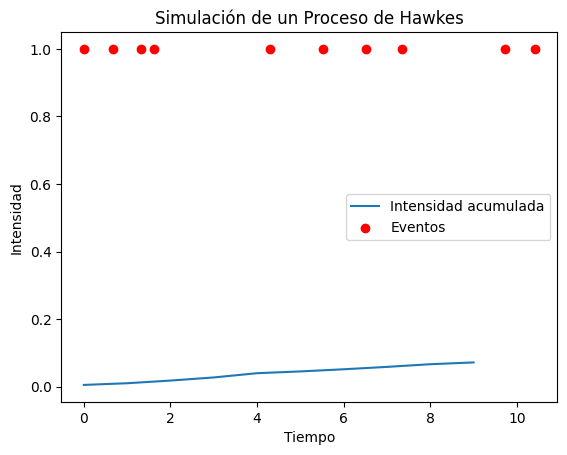

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del proceso de Hawkes
lambda_0 = 0.5  # Tasa base
alpha = 0.8     # Parámetro de excitación
beta = 1.5      # Parámetro de decaimiento

# Tiempo de simulación
T = 10
dt = 0.01

# Inicialización
times = [0]
lambda_t = lambda_0
intensity = [lambda_0]

# Simulación del proceso de Hawkes
while times[-1] < T:
    current_time = times[-1]
    lambda_t = lambda_0 + alpha * np.sum(np.exp(-beta * (current_time - np.array(times[:-1]))))
    intensity.append(lambda_t)
    
    # Tiempo hasta el siguiente evento
    wait_time = np.random.exponential(scale=1/lambda_t)
    times.append(current_time + wait_time)

# Visualización
plt.plot(np.cumsum(intensity) * dt, label='Intensidad acumulada')
plt.scatter(times, np.ones_like(times), color='red', label='Eventos')
plt.xlabel('Tiempo')
plt.ylabel('Intensidad')
plt.title('Simulación de un Proceso de Hawkes')
plt.legend()
plt.show()


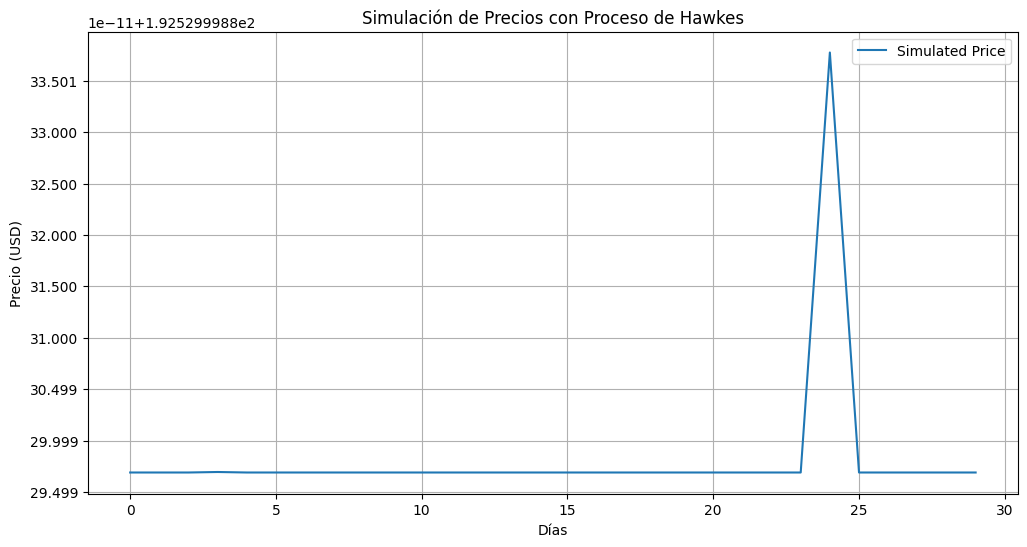

In [11]:
def generate_price_series(initial_price, events, mu, alpha, beta, T, dt=1):
    """
    Genera una serie temporal de precios a partir de eventos simulados.
    
    Args:
    - initial_price: precio inicial de la serie.
    - events: tiempos de eventos simulados.
    - mu, alpha, beta: parámetros del proceso de Hawkes.
    - T: tiempo total de la simulación.
    - dt: intervalo de tiempo de la serie temporal.
    
    Returns:
    - time_series: array de tiempos de la serie.
    - price_series: array de precios simulados.
    """
    # Initialize time series
    time_series = np.arange(0, T, dt)
    price_series = np.full_like(time_series, initial_price, dtype=float)

    # Simulate price changes
    for i, t in enumerate(time_series[1:], start=1):
        # Count events in the current interval
        num_events = np.sum((events >= time_series[i-1]) & (events < t))

        # Calculate price change
        if num_events > 0:
            decay_factors = np.exp(-beta * (t - events[events < t]))
            price_change = alpha * np.sum(decay_factors)
            price_series[i] += price_change
    
    return time_series, price_series

# Generate price series with the corrected function
initial_price = data['Close'].iloc[-1]  # Último precio conocido
time_series, price_series = generate_price_series(initial_price, simulated_events, mu_mle, alpha_mle, beta_mle, T_future)

# Plot the simulated price series
plt.figure(figsize=(12, 6))
plt.plot(time_series, price_series, label='Simulated Price')
plt.title('Simulación de Precios con Proceso de Hawkes')
plt.xlabel('Días')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.show()


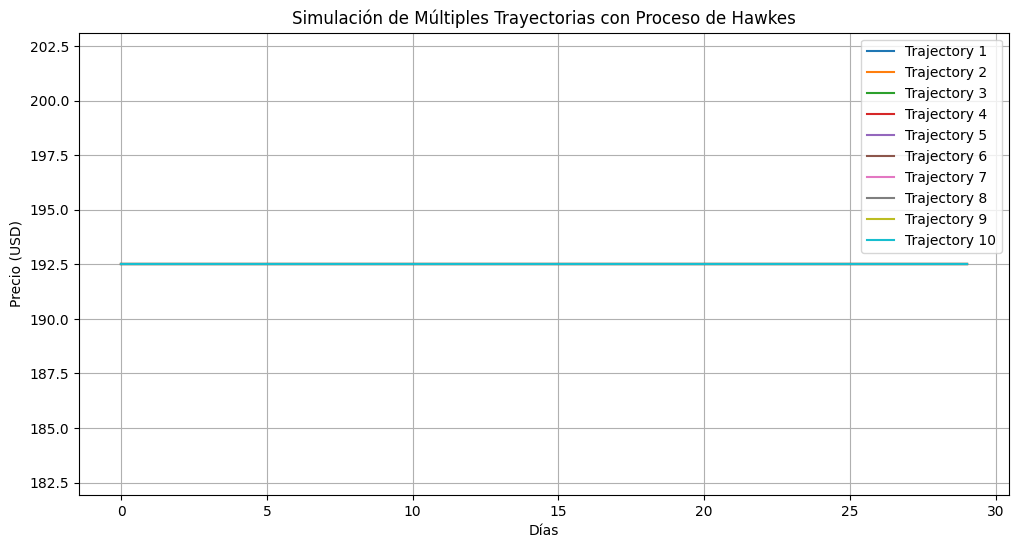

In [12]:
def simulate_multiple_trajectories(mu, alpha, beta, T, num_simulations=10):
    """
    Simula múltiples trayectorias del proceso de Hawkes.
    
    Args:
    - mu, alpha, beta: parámetros del proceso de Hawkes.
    - T: tiempo total de la simulación.
    - num_simulations: número de trayectorias a simular.
    
    Returns:
    - trajectories: lista de arrays de precios simulados.
    """
    trajectories = []
    for _ in range(num_simulations):
        events = simulate_hawkes(mu, alpha, beta, T)
        _, prices = generate_price_series(initial_price, events, mu, alpha, beta, T)
        trajectories.append(prices)
    
    return trajectories

# Simulate multiple trajectories
num_simulations = 10
trajectories = simulate_multiple_trajectories(mu_mle, alpha_mle, beta_mle, T_future, num_simulations)

# Plot the simulated trajectories
plt.figure(figsize=(12, 6))
for i, trajectory in enumerate(trajectories):
    plt.plot(time_series, trajectory, label=f'Trajectory {i+1}')
plt.title('Simulación de Múltiples Trayectorias con Proceso de Hawkes')
plt.xlabel('Días')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
def generate_price_series(initial_price, events, mu, alpha, beta, T, dt=1):
    """
    Genera una serie temporal de precios a partir de eventos simulados.
    
    Args:
    - initial_price: precio inicial de la serie.
    - events: tiempos de eventos simulados.
    - mu, alpha, beta: parámetros del proceso de Hawkes.
    - T: tiempo total de la simulación.
    - dt: intervalo de tiempo de la serie temporal.
    
    Returns:
    - time_series: array de tiempos de la serie.
    - price_series: array de precios simulados.
    """
    # Inicializar series temporales
    time_series = np.arange(0, T, dt)
    price_series = np.full_like(time_series, initial_price, dtype=float)

    # Simular cambios de precio
    for i, t in enumerate(time_series[1:], start=1):
        num_events = np.sum((events >= time_series[i-1]) & (events < t))
        price_series[i] += num_events * alpha * np.exp(-beta * (t - events[events < t]))

    return time_series, price_series

# Generar serie temporal de precios
initial_price = data['Close'].iloc[-1]  # Último precio conocido
time_series, price_series = generate_price_series(initial_price, simulated_events, mu_est, alpha_est, beta_est, T_future)

# Graficar la serie temporal simulada
plt.figure(figsize=(12, 6))
plt.plot(time_series, price_series, label='Simulated Price')
plt.title('Simulación de Precios con Proceso de Hawkes')
plt.xlabel('Días')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.show()


ValueError: setting an array element with a sequence.

In [ ]:
def simulate_multiple_trajectories(mu, alpha, beta, T, num_simulations=10):
    """
    Simula múltiples trayectorias del proceso de Hawkes.
    
    Args:
    - mu, alpha, beta: parámetros del proceso de Hawkes.
    - T: tiempo total de la simulación.
    - num_simulations: número de trayectorias a simular.
    
    Returns:
    - trajectories: lista de arrays de precios simulados.
    """
    trajectories = []
    for _ in range(num_simulations):
        events = simulate_hawkes(mu, alpha, beta, T)
        _, prices = generate_price_series(initial_price, events, mu, alpha, beta, T)
        trajectories.append(prices)
    
    return trajectories

# Simular múltiples trayectorias
num_simulations = 10
trajectories = simulate_multiple_trajectories(mu_est, alpha_est, beta_est, T_future, num_simulations)

# Graficar las trayectorias simuladas
plt.figure(figsize=(12, 6))
for i, trajectory in enumerate(trajectories):
    plt.plot(time_series, trajectory, label=f'Trajectory {i+1}')
plt.title('Simulación de Múltiples Trayectorias con Proceso de Hawkes')
plt.xlabel('Días')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.show()
